In [1]:
#!pip install -U yellowbrick

In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import PredictionError
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
%%time
ticket_scans = pd.read_csv('Ticket Scan Data.csv')
game_data = pd.read_csv('Game Data.csv')
team_data = pd.read_csv('Team Data.csv')
section_data = pd.read_csv('Seating Chart.csv')

CPU times: user 874 ms, sys: 78.8 ms, total: 953 ms
Wall time: 956 ms


In [4]:
ticket_scans.head()

,scan_unique_id,event_name,event_datetime,section_name,row_name,seat_number,scan_gate,scan_location,scan_datetime
0,124908643:19208870,LA Clippers 2018-2019 Game 14 - Dallas - 12/20/18,2018-12-20 19:30:00,332,8,23,11th Street - Door 1,STAPLES Center (Premium),2018-12-20 20:50:45
1,124908643:19309978,LA Clippers 2018-2019 Game 23 - Utah - 01/16/19,2019-01-16 19:30:00,304,8,16,11th Street - Door 2,STAPLES Center (Premium),2019-01-16 21:02:08
2,124908643:19198830,LA Clippers 2018-2019 Game 13 - Portland - 12/...,2018-12-17 19:30:00,207,10,15,Star Plaza - Door 1,STAPLES Center (Premium),2018-12-17 20:54:52
3,124908643:19233811,LA Clippers 2018-2019 Game 16 - Sacramento - 1...,2018-12-26 19:30:00,107,D,6,Figueroa - Door 4,STAPLES Center (Premium),2018-12-26 21:07:30
4,124908643:19215364,LA Clippers 2018-2019 Game 14 - Dallas - 12/20/18,2018-12-20 19:30:00,107,10,13,Star Plaza - Door 6,STAPLES Center (Premium),2018-12-20 21:55:18


In [5]:
ticket_scans['scan_datetime'] = pd.to_datetime(ticket_scans['scan_datetime'])
ticket_scans['event_datetime'] = pd.to_datetime(ticket_scans['event_datetime'])
ticket_scans['time_diff'] = (ticket_scans['scan_datetime'] - ticket_scans['event_datetime']).progress_apply(lambda x: int(x.total_seconds() //60))
def get_timebin(x):
    if x >= 0:
        return f'{(x//15+1)*15}-{x//15*15} Before'
    else:
        x = -1 * x
        return f'{(x//15+1)*15}-{x//15*15} After'
    
ticket_scans['time_diff'] = ticket_scans['time_diff'].progress_apply(get_timebin)

In [6]:
time_period = ticket_scans['time_diff'].unique().tolist()

In [7]:
ticket_scans = pd.get_dummies(ticket_scans, columns=['time_diff'])

In [8]:
ticket_scans.columns = [column.replace('time_diff_', '') for column in ticket_scans.columns]
ticket_scans['scan_unique_id'] = 1

In [9]:
ticket_scans.head()

,scan_unique_id,event_name,event_datetime,section_name,row_name,seat_number,scan_gate,scan_location,scan_datetime,105-90 After,105-90 Before,120-105 Before,135-120 After,135-120 Before,15-0 After,15-0 Before,150-135 Before,165-150 Before,180-165 Before,195-180 Before,210-195 Before,225-210 Before,240-225 Before,255-240 Before,270-255 Before,285-270 Before,30-15 After,30-15 Before,300-285 Before,45-30 After,45-30 Before,60-45 After,60-45 Before,75-60 After,75-60 Before,90-75 After,90-75 Before
0,1,LA Clippers 2018-2019 Game 14 - Dallas - 12/20/18,2018-12-20 19:30:00,332,8,23,11th Street - Door 1,STAPLES Center (Premium),2018-12-20 20:50:45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,LA Clippers 2018-2019 Game 23 - Utah - 01/16/19,2019-01-16 19:30:00,304,8,16,11th Street - Door 2,STAPLES Center (Premium),2019-01-16 21:02:08,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,LA Clippers 2018-2019 Game 13 - Portland - 12/...,2018-12-17 19:30:00,207,10,15,Star Plaza - Door 1,STAPLES Center (Premium),2018-12-17 20:54:52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,LA Clippers 2018-2019 Game 16 - Sacramento - 1...,2018-12-26 19:30:00,107,D,6,Figueroa - Door 4,STAPLES Center (Premium),2018-12-26 21:07:30,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,LA Clippers 2018-2019 Game 14 - Dallas - 12/20/18,2018-12-20 19:30:00,107,10,13,Star Plaza - Door 6,STAPLES Center (Premium),2018-12-20 21:55:18,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
%%time
ticket_scans['City'] = ticket_scans['event_name'].progress_apply(lambda x: x.split('-')[-2][1:-1])
ticket_scans['event_datetime'] = ticket_scans['event_datetime'].dt.normalize()
ticket_scans = ticket_scans.groupby(['City', 'event_datetime', 'section_name'])[time_period+['scan_unique_id']].sum().reset_index().rename(columns = {'scan_unique_id':'attendees'})
ticket_scans.head()


CPU times: user 936 ms, sys: 47.8 ms, total: 984 ms
Wall time: 983 ms


In [11]:
section_names = list(map(lambda x: str(x), ticket_scans['section_name'].unique()))

In [12]:
%%time
section_dict = {}
for i in tqdm(range(59)):
    section_dict[int(ticket_scans['section_name'].tolist()[i::59][0])] = ticket_scans['attendees'].tolist()[i::59]

section_dict = pd.DataFrame(section_dict)
section_dict.head()


CPU times: user 46 ms, sys: 4.07 ms, total: 50.1 ms
Wall time: 60.7 ms


In [13]:
%%time
ticket_scans = ticket_scans.groupby(['City', 'event_datetime'])[time_period+['attendees']].sum().reset_index()
for key in tqdm(section_dict.columns):
    ticket_scans[key] = section_dict[key]
ticket_scans.head()


CPU times: user 72.2 ms, sys: 2.08 ms, total: 74.3 ms
Wall time: 89.1 ms


In [14]:
%%time
ticket_scans['City'] = ticket_scans['City'].replace('Golden State', 'Oakland')

CPU times: user 1.23 ms, sys: 0 ns, total: 1.23 ms
Wall time: 1.35 ms


In [15]:
%%time
df = ticket_scans.merge(team_data[team_data['Team Full Name'] != 'Los Angeles Clippers'], on = 'City', how = 'left')
df['event_datetime'] = pd.to_datetime(df['event_datetime'])
df.head()

CPU times: user 28.2 ms, sys: 0 ns, total: 28.2 ms
Wall time: 31.9 ms


In [16]:
df.columns = list(map(lambda x: str(x), df.keys()))

In [17]:
%%time
game_data['Date'] = pd.to_datetime(game_data['Date'], format  = '%a, %b %d, %Y')

CPU times: user 4.22 ms, sys: 0 ns, total: 4.22 ms
Wall time: 4.49 ms


In [18]:
df = df.merge(game_data, left_on = ['event_datetime', 'Team Full Name'], right_on = ['Date', 'Opponent'], how = 'left')

In [19]:
df.isna().sum()[df.isna().sum()>0]

Series([], dtype: int64)

In [20]:
section = section_data.groupby('section_name')['seat_count'].sum().reset_index().transpose()
section.columns = section.iloc[0]
section = section.drop(section.index[0])

In [21]:
for key in tqdm(section.keys()):
    if key in df.keys():
        df[key] = df[key] / section[key][0] * 100

In [22]:
df.head()

,City,event_datetime,90-75 Before,105-90 Before,150-135 Before,45-30 Before,75-60 Before,165-150 Before,210-195 Before,135-120 Before,240-225 Before,60-45 Before,30-15 Before,120-105 Before,15-0 Before,180-165 Before,225-210 Before,45-30 After,195-180 Before,255-240 Before,15-0 After,270-255 Before,60-45 After,135-120 After,30-15 After,300-285 Before,75-60 After,285-270 Before,90-75 After,105-90 After,attendees,103,104,105,106,107,108,109,113,114,115,116,117,118,205,206,207,208,209,210,214,215,216,217,218,219,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,Team Code,Team,Team Full Name,Founded,Joined NBA,Conference,Arena,Arena City-State,Capacity,Lat,Long,Year Opened,Playoffs in last year,Championships,Vegas Odds for 1819,Game Number,Date,Start Time,Game Type,Opponent,Result,Overtime,Clippers Points,Opponent Points,Total Wins,Total Losses,Streak
0,Atlanta,2019-01-28,851.0,1167.0,623.0,476.0,577.0,375.0,41.0,1300.0,14.0,435.0,24.0,1578.0,217.0,142.0,22.0,0.0,80.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7924,71.568627,71.323529,77.952756,82.297552,75.243665,66.949153,58.986175,70.443350,66.292135,81.835938,80.075188,74.055416,78.240741,63.768116,52.307692,78.609626,87.500000,84.375000,78.260870,76.086957,82.291667,83.870968,84.408602,72.448980,68.115942,69.354839,47.169811,56.457565,51.063830,56.287425,56.849315,59.223301,58.064516,58.426966,58.426966,48.387097,44.565217,27.814570,69.127517,53.424658,54.852321,44.520548,60.775862,51.020408,64.135021,39.269406,71.812081,36.000000,6.521739,22.580645,25.000000,10.000000,9.677419,32.692308,39.864865,55.688623,62.411348,46.323529,60.150376,ATL,Hawks,Atlanta Hawks,1946,1949,Eastern,State Farm Arena,"Atlanta, Georgia",18118,33.757294,-84.398513,1999,No,1,23.5,51,2019-01-28,10:30p,Regular Season Home,Atlanta Hawks,L,No,118,123,28,23,L 1
1,Boston,2019-03-11,1288.0,1700.0,744.0,948.0,857.0,297.0,38.0,1547.0,4.0,530.0,61.0,1704.0,184.0,123.0,12.0,1.0,55.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10101,82.843137,78.676471,90.551181,91.148776,84.795322,84.322034,73.732719,77.339901,73.314607,88.867188,85.714286,82.619647,88.888889,95.652174,96.410256,87.700535,79.347826,93.229167,88.405797,90.579710,88.020833,81.720430,93.548387,93.367347,87.681159,94.892473,76.226415,75.276753,81.560284,92.215569,87.671233,82.524272,72.043011,87.640449,92.134831,69.892473,85.869565,54.966887,72.483221,54.337900,69.198312,64.383562,95.689655,70.748299,77.637131,78.082192,85.234899,44.000000,72.826087,70.967742,81.818182,82.222222,66.666667,60.576923,75.000000,70.059880,85.460993,64.705882,73.684211,BOS,Celtics,Boston Celtics,1946,1946,Eastern,TD Garden,"Boston, Massachusetts",18624,42.366202,-71.064335,1995,Yes,17,57.5,68,2019-03-11,10:30p,Regular Season Home,Boston Celtics,W,No,140,115,39,29,W 5
2,Brooklyn,2019-03-17,879.0,1083.0,697.0,464.0,663.0,385.0,102.0,1390.0,15.0,545.0,254.0,1492.0,288.0,202.0,19.0,0.0,106.0,4.0,18.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8609,74.509804,75.000000,81.889764,82.109228,76.803119,68.432203,75.576037,66.995074,62.359551,75.390625,75.563910,69.017632,84.259259,81.884058,94.358974,90.909091,80.978261,85.937500,84.782609,85.507246,91.145833,89.247312,85.483871,84.183673,86.231884,67.473118,47.169811,58.671587,68.794326,70.658683,63.013699,61.165049,56.989247,70.786517,85.393258,50.537634,42.391304,59.602649,77.181208,61.643836,17.299578,69.178082,50.431034,65.986395,69.620253,57.077626,59.731544,59.333333,29.347826,17.204301,20.454545,68.888889,29.032258,66.346154,62.837838,68.263473,63.475177,75.367647,65.413534,BRK,Nets,Brooklyn Nets,1967,1976,Eastern,Barclays Center,"Brooklyn, New York",17732,40.682654,-73.977602,2012,No,0,32.5,71,2019-03-17,9:00p,Regular Season Home,Brooklyn Nets,W,No,119,116,41,30,W 2
3,Charlotte,2019-01-08,730.0,1039.0,584.0,408.0,440.0,304.0,52.0,1120.0,5.0,275.0,98.0,1291.0,241.0,146.0,20.0,0.0,110.0,5.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6873,63.725490,

In [23]:
%%time
df['week_day'] = df['event_datetime'].dt.day_name()
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
week_day = df.groupby('week_day')['attendees'].mean().reindex(cats).reset_index()
weekends = week_day[week_day['week_day'].isin(['Friday', 'Saturday', 'Sunday'])]

CPU times: user 11.7 ms, sys: 1.99 ms, total: 13.6 ms
Wall time: 14.8 ms


In [24]:
df['is_weekend'] = df['week_day'].apply(lambda x: 'Weekend' if x in ['Friday', 'Saturday', 'Sunday'] else 'Weekday')
weekend = df.groupby('is_weekend')['attendees'].mean().reset_index()
print(weekend)

  is_weekend    attendees
0    Weekday  8356.272727
1    Weekend  8507.105263


[]

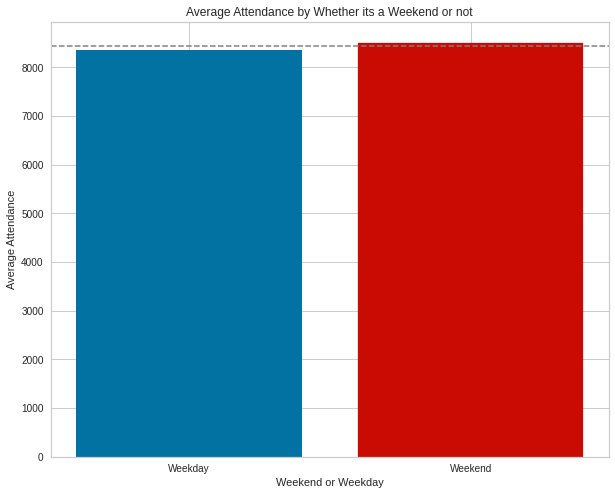

In [25]:
plt.figure(figsize = (10,8))
bar = plt.bar(weekend['is_weekend'], weekend['attendees'])
bar[1].set_color('r')
plt.axhline(y = weekend['attendees'].mean(), color = 'grey', linestyle = '--', linewidth = 1.5)
plt.title('Average Attendance by Whether its a Weekend or not')
plt.ylabel('Average Attendance')
plt.xlabel('Weekend or Weekday')
plt.plot()

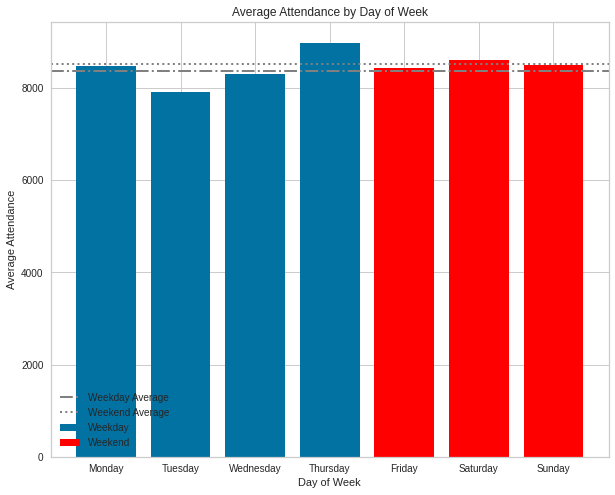

In [26]:
plt.figure(figsize = (10,8))
ax = plt.gca()
plt.bar(week_day['week_day'], week_day['attendees'], label = 'Weekday')
plt.bar(weekends['week_day'], weekends['attendees'], color = 'red', label = 'Weekend')
plt.axhline(y = 8356.272727, color = 'grey', linestyle = '-.', linewidth = 2, label = 'Weekday Average')
plt.axhline(y = 8507.105263, color = 'grey', linestyle = ':', linewidth = 2, label = 'Weekend Average')
plt.title('Average Attendance by Day of Week')
plt.ylabel('Average Attendance')
plt.xlabel('Day of Week')
plt.legend()
plt.show()

In [27]:
df.head()

,City,event_datetime,90-75 Before,105-90 Before,150-135 Before,45-30 Before,75-60 Before,165-150 Before,210-195 Before,135-120 Before,240-225 Before,60-45 Before,30-15 Before,120-105 Before,15-0 Before,180-165 Before,225-210 Before,45-30 After,195-180 Before,255-240 Before,15-0 After,270-255 Before,60-45 After,135-120 After,30-15 After,300-285 Before,75-60 After,285-270 Before,90-75 After,105-90 After,attendees,103,104,105,106,107,108,109,113,114,115,116,117,118,205,206,207,208,209,210,214,215,216,217,218,219,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,Team Code,Team,Team Full Name,Founded,Joined NBA,Conference,Arena,Arena City-State,Capacity,Lat,Long,Year Opened,Playoffs in last year,Championships,Vegas Odds for 1819,Game Number,Date,Start Time,Game Type,Opponent,Result,Overtime,Clippers Points,Opponent Points,Total Wins,Total Losses,Streak,week_day,is_weekend
0,Atlanta,2019-01-28,851.0,1167.0,623.0,476.0,577.0,375.0,41.0,1300.0,14.0,435.0,24.0,1578.0,217.0,142.0,22.0,0.0,80.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7924,71.568627,71.323529,77.952756,82.297552,75.243665,66.949153,58.986175,70.443350,66.292135,81.835938,80.075188,74.055416,78.240741,63.768116,52.307692,78.609626,87.500000,84.375000,78.260870,76.086957,82.291667,83.870968,84.408602,72.448980,68.115942,69.354839,47.169811,56.457565,51.063830,56.287425,56.849315,59.223301,58.064516,58.426966,58.426966,48.387097,44.565217,27.814570,69.127517,53.424658,54.852321,44.520548,60.775862,51.020408,64.135021,39.269406,71.812081,36.000000,6.521739,22.580645,25.000000,10.000000,9.677419,32.692308,39.864865,55.688623,62.411348,46.323529,60.150376,ATL,Hawks,Atlanta Hawks,1946,1949,Eastern,State Farm Arena,"Atlanta, Georgia",18118,33.757294,-84.398513,1999,No,1,23.5,51,2019-01-28,10:30p,Regular Season Home,Atlanta Hawks,L,No,118,123,28,23,L 1,Monday,Weekday
1,Boston,2019-03-11,1288.0,1700.0,744.0,948.0,857.0,297.0,38.0,1547.0,4.0,530.0,61.0,1704.0,184.0,123.0,12.0,1.0,55.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10101,82.843137,78.676471,90.551181,91.148776,84.795322,84.322034,73.732719,77.339901,73.314607,88.867188,85.714286,82.619647,88.888889,95.652174,96.410256,87.700535,79.347826,93.229167,88.405797,90.579710,88.020833,81.720430,93.548387,93.367347,87.681159,94.892473,76.226415,75.276753,81.560284,92.215569,87.671233,82.524272,72.043011,87.640449,92.134831,69.892473,85.869565,54.966887,72.483221,54.337900,69.198312,64.383562,95.689655,70.748299,77.637131,78.082192,85.234899,44.000000,72.826087,70.967742,81.818182,82.222222,66.666667,60.576923,75.000000,70.059880,85.460993,64.705882,73.684211,BOS,Celtics,Boston Celtics,1946,1946,Eastern,TD Garden,"Boston, Massachusetts",18624,42.366202,-71.064335,1995,Yes,17,57.5,68,2019-03-11,10:30p,Regular Season Home,Boston Celtics,W,No,140,115,39,29,W 5,Monday,Weekday
2,Brooklyn,2019-03-17,879.0,1083.0,697.0,464.0,663.0,385.0,102.0,1390.0,15.0,545.0,254.0,1492.0,288.0,202.0,19.0,0.0,106.0,4.0,18.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8609,74.509804,75.000000,81.889764,82.109228,76.803119,68.432203,75.576037,66.995074,62.359551,75.390625,75.563910,69.017632,84.259259,81.884058,94.358974,90.909091,80.978261,85.937500,84.782609,85.507246,91.145833,89.247312,85.483871,84.183673,86.231884,67.473118,47.169811,58.671587,68.794326,70.658683,63.013699,61.165049,56.989247,70.786517,85.393258,50.537634,42.391304,59.602649,77.181208,61.643836,17.299578,69.178082,50.431034,65.986395,69.620253,57.077626,59.731544,59.333333,29.347826,17.204301,20.454545,68.888889,29.032258,66.346154,62.837838,68.263473,63.475177,75.367647,65.413534,BRK,Nets,Brooklyn Nets,1967,1976,Eastern,Barclays Center,"Brooklyn, New York",17732,40.682654,-73.977602,2012,No,0,32.5,71,2019-03-17,9:00p,Regular Season Home,Brooklyn Nets,W,No,119,116,41,30,W 2,Sunday,Weekend
3,Charlotte,2019-01-08,730.0,1039.0,584.0,408.0,440.0,304.0,52.0,1120.0,5.0,275.0,98.0,1291.0,241.0,146.0,20.0,0.0,

In [28]:
top4_attendance = df.groupby('Opponent')['attendees'].mean().reset_index().sort_values(by = 'attendees', ascending = False).head(4)
top4_attendance = top4_attendance.reset_index(drop = True)
top4_attendance

,Opponent,attendees
0,Boston Celtics,10101.0
1,Golden State Warriors,9797.5
2,Los Angeles Lakers,9477.0
3,New York Knicks,9432.0


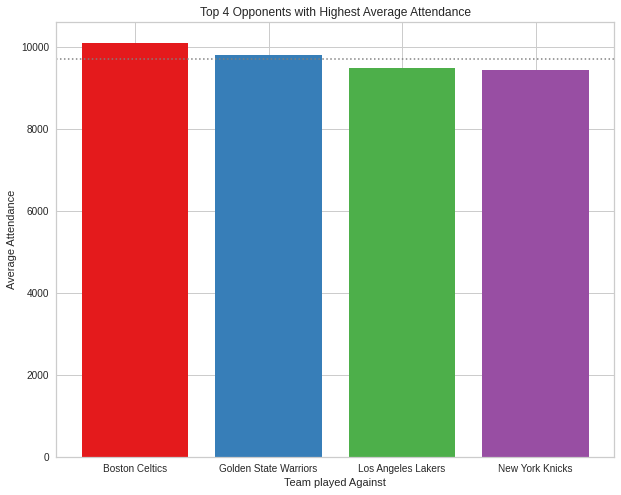

In [29]:
plt.figure(figsize = (10,8))
plt.bar(top4_attendance['Opponent'], top4_attendance['attendees'], color = sns.color_palette('Set1'))
plt.axhline(y = top4_attendance['attendees'].mean(), color = 'grey', linestyle = ':', linewidth = 1.5)
plt.title('Top 4 Opponents with Highest Average Attendance')
plt.ylabel('Average Attendance')
plt.xlabel("Team played Against")
plt.show()

In [30]:
top10_sections = df[section_names].mean().reset_index().sort_values(by = 0, ascending = False).head(10)
top10_sections = top10_sections.rename(columns = {'index': 'section_name', 0: 'percentage_filled'}).reset_index(drop = True)
top10_sections = top10_sections.reset_index().rename(columns = {'index': 'rank'})
top10_sections['rank'] = top10_sections['rank'] + 1
top10_sections

,rank,section_name,percentage_filled
0,1,207,79.353072
1,2,309,78.980543
2,3,106,78.622939
3,4,118,78.161698
4,5,215,77.362805
5,6,116,77.301485
6,7,206,76.610381
7,8,105,76.445170
8,9,310,75.774185
9,10,217,75.347495


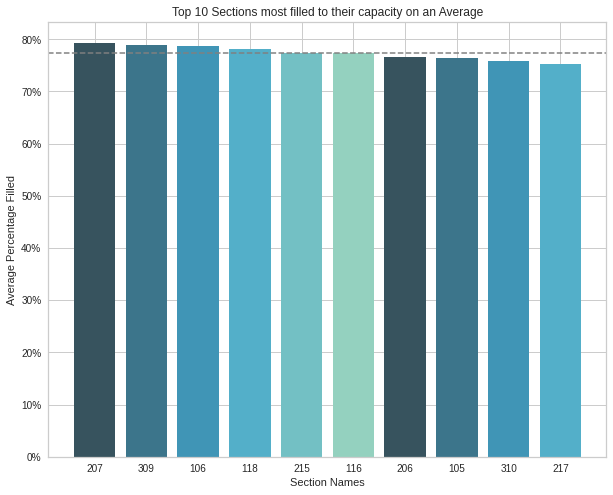

In [31]:
plt.figure(figsize = (10,8))
plt.bar(top10_sections['section_name'], top10_sections['percentage_filled'], color = sns.color_palette("GnBu_d"))
plt.axhline(y = top10_sections['percentage_filled'].mean(), color = 'grey', linestyle = '--', linewidth = 1.5)
ax = plt.gca()
vals = ax.get_yticks()
vals = [str(int(val))+'%' for val in vals]
ax.set_yticklabels(vals)
plt.title('Top 10 Sections most filled to their capacity on an Average')
plt.ylabel('Average Percentage Filled')
plt.xlabel('Section Names')
plt.show()

In [32]:
df.head()

,City,event_datetime,90-75 Before,105-90 Before,150-135 Before,45-30 Before,75-60 Before,165-150 Before,210-195 Before,135-120 Before,240-225 Before,60-45 Before,30-15 Before,120-105 Before,15-0 Before,180-165 Before,225-210 Before,45-30 After,195-180 Before,255-240 Before,15-0 After,270-255 Before,60-45 After,135-120 After,30-15 After,300-285 Before,75-60 After,285-270 Before,90-75 After,105-90 After,attendees,103,104,105,106,107,108,109,113,114,115,116,117,118,205,206,207,208,209,210,214,215,216,217,218,219,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,Team Code,Team,Team Full Name,Founded,Joined NBA,Conference,Arena,Arena City-State,Capacity,Lat,Long,Year Opened,Playoffs in last year,Championships,Vegas Odds for 1819,Game Number,Date,Start Time,Game Type,Opponent,Result,Overtime,Clippers Points,Opponent Points,Total Wins,Total Losses,Streak,week_day,is_weekend
0,Atlanta,2019-01-28,851.0,1167.0,623.0,476.0,577.0,375.0,41.0,1300.0,14.0,435.0,24.0,1578.0,217.0,142.0,22.0,0.0,80.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7924,71.568627,71.323529,77.952756,82.297552,75.243665,66.949153,58.986175,70.443350,66.292135,81.835938,80.075188,74.055416,78.240741,63.768116,52.307692,78.609626,87.500000,84.375000,78.260870,76.086957,82.291667,83.870968,84.408602,72.448980,68.115942,69.354839,47.169811,56.457565,51.063830,56.287425,56.849315,59.223301,58.064516,58.426966,58.426966,48.387097,44.565217,27.814570,69.127517,53.424658,54.852321,44.520548,60.775862,51.020408,64.135021,39.269406,71.812081,36.000000,6.521739,22.580645,25.000000,10.000000,9.677419,32.692308,39.864865,55.688623,62.411348,46.323529,60.150376,ATL,Hawks,Atlanta Hawks,1946,1949,Eastern,State Farm Arena,"Atlanta, Georgia",18118,33.757294,-84.398513,1999,No,1,23.5,51,2019-01-28,10:30p,Regular Season Home,Atlanta Hawks,L,No,118,123,28,23,L 1,Monday,Weekday
1,Boston,2019-03-11,1288.0,1700.0,744.0,948.0,857.0,297.0,38.0,1547.0,4.0,530.0,61.0,1704.0,184.0,123.0,12.0,1.0,55.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10101,82.843137,78.676471,90.551181,91.148776,84.795322,84.322034,73.732719,77.339901,73.314607,88.867188,85.714286,82.619647,88.888889,95.652174,96.410256,87.700535,79.347826,93.229167,88.405797,90.579710,88.020833,81.720430,93.548387,93.367347,87.681159,94.892473,76.226415,75.276753,81.560284,92.215569,87.671233,82.524272,72.043011,87.640449,92.134831,69.892473,85.869565,54.966887,72.483221,54.337900,69.198312,64.383562,95.689655,70.748299,77.637131,78.082192,85.234899,44.000000,72.826087,70.967742,81.818182,82.222222,66.666667,60.576923,75.000000,70.059880,85.460993,64.705882,73.684211,BOS,Celtics,Boston Celtics,1946,1946,Eastern,TD Garden,"Boston, Massachusetts",18624,42.366202,-71.064335,1995,Yes,17,57.5,68,2019-03-11,10:30p,Regular Season Home,Boston Celtics,W,No,140,115,39,29,W 5,Monday,Weekday
2,Brooklyn,2019-03-17,879.0,1083.0,697.0,464.0,663.0,385.0,102.0,1390.0,15.0,545.0,254.0,1492.0,288.0,202.0,19.0,0.0,106.0,4.0,18.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8609,74.509804,75.000000,81.889764,82.109228,76.803119,68.432203,75.576037,66.995074,62.359551,75.390625,75.563910,69.017632,84.259259,81.884058,94.358974,90.909091,80.978261,85.937500,84.782609,85.507246,91.145833,89.247312,85.483871,84.183673,86.231884,67.473118,47.169811,58.671587,68.794326,70.658683,63.013699,61.165049,56.989247,70.786517,85.393258,50.537634,42.391304,59.602649,77.181208,61.643836,17.299578,69.178082,50.431034,65.986395,69.620253,57.077626,59.731544,59.333333,29.347826,17.204301,20.454545,68.888889,29.032258,66.346154,62.837838,68.263473,63.475177,75.367647,65.413534,BRK,Nets,Brooklyn Nets,1967,1976,Eastern,Barclays Center,"Brooklyn, New York",17732,40.682654,-73.977602,2012,No,0,32.5,71,2019-03-17,9:00p,Regular Season Home,Brooklyn Nets,W,No,119,116,41,30,W 2,Sunday,Weekend
3,Charlotte,2019-01-08,730.0,1039.0,584.0,408.0,440.0,304.0,52.0,1120.0,5.0,275.0,98.0,1291.0,241.0,146.0,20.0,0.0,

In [33]:
df['attendees'].corr(df['Vegas Odds for 1819'])

0.1606018452630534

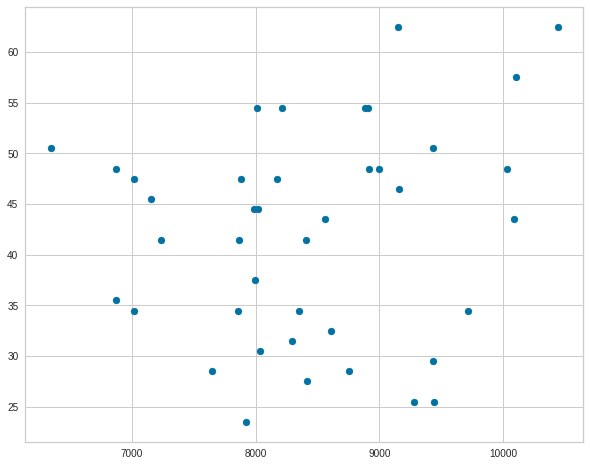

In [34]:
plt.figure(figsize = (10,8))
plt.scatter(df['attendees'], df['Vegas Odds for 1819'])
plt.show()

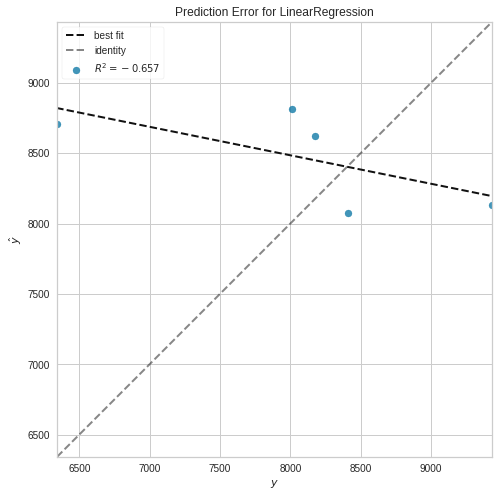

In [35]:
X = df[['Vegas Odds for 1819']]
y = df['attendees']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

plt.figure(figsize = (10,8))
ax = plt.gca()

model = LinearRegression(n_jobs = -1, normalize = True)
visualizer = PredictionError(model, ax = ax)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show()
#plt.show()

In [36]:
top10_time_period = df[time_period].mean().reset_index().rename(columns = {'index': 'time_period', 0: 'avg_number_of_scans'}).sort_values(by = 'avg_number_of_scans', ascending = False).head(10)
top10_time_period.head(1)

,time_period,avg_number_of_scans
11,120-105 Before,1506.926829


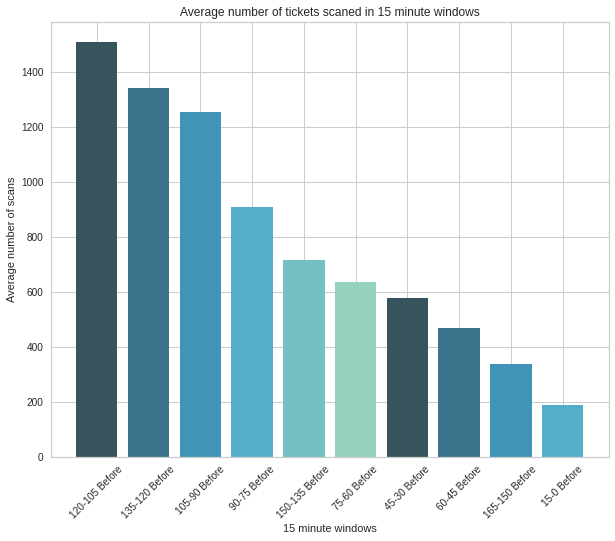

In [37]:
plt.figure(figsize = (10, 8))
plt.bar(top10_time_period['time_period'], top10_time_period['avg_number_of_scans'], color = sns.color_palette("GnBu_d"))
plt.xticks(rotation=45)
plt.title('Average number of tickets scaned in 15 minute windows')
plt.xlabel('15 minute windows')
plt.ylabel('Average number of scans')
plt.show()